In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import chi2_kernel
from scipy.spatial.distance import canberra

In [2]:
# Здесь я изменил переменную DATA_PATH, если что. 
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

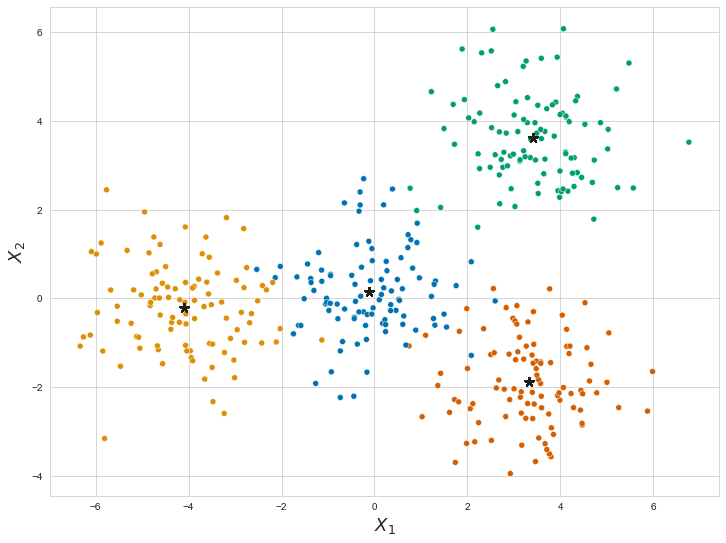

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False, sleep = False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
            :param sleep: при визуализации задает время в секундах между итерациями (для наглядности)
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
        self.sleep = sleep
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                if self.sleep:
                    time.sleep(self.sleep)
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        for _ in range(self.max_iter):
            dists = []
            for centroid in self.centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            cluster_labels = np.argmin(dists, axis=1)
            
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """

        
        return np.sqrt(np.sum((X - centroid)**2,axis=1)).reshape(X.shape[0],1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

### Пример для визуализации:

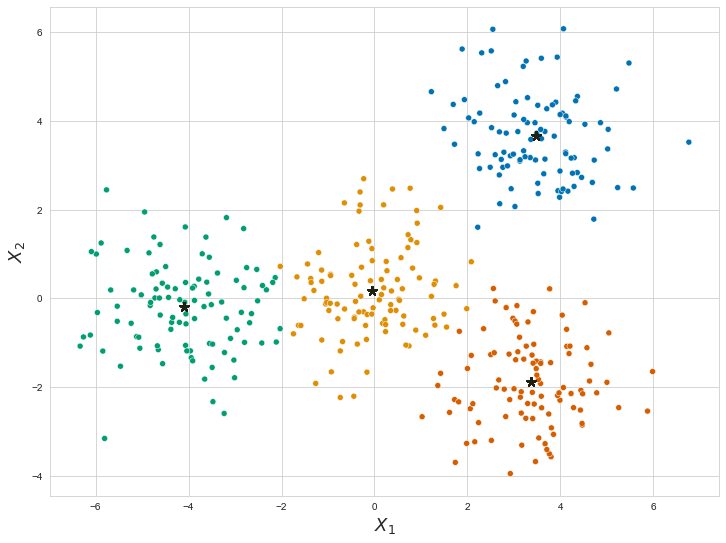

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
model = MyKMeans(4,max_iter=6,visualize=True,sleep=1)
model.fit(X)

## Пример для prediction

In [8]:
# Не удобно кластеры сравнивать между собой, так как модель задает им рандомные метки в з-ти от начальных кластеров
from sklearn.metrics import adjusted_rand_score

In [9]:
# 1 random centroides
model = MyKMeans(n_clusters=4)
model.fit(X)

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [10]:
prediction = model.predict(X)

In [11]:
adjusted_rand_score(true_labels, prediction)

0.9278697796079957

In [12]:
# 2 sample centroides 
model = MyKMeans(n_clusters=4,init='sample')
model.fit(X)

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [13]:
prediction = model.predict(X)

In [14]:
adjusted_rand_score(true_labels, prediction)

0.9278697796079957

Результат примерно одинаковый для max_iter = 300

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [15]:
data = load_digits()
X, y = data.data, data.target

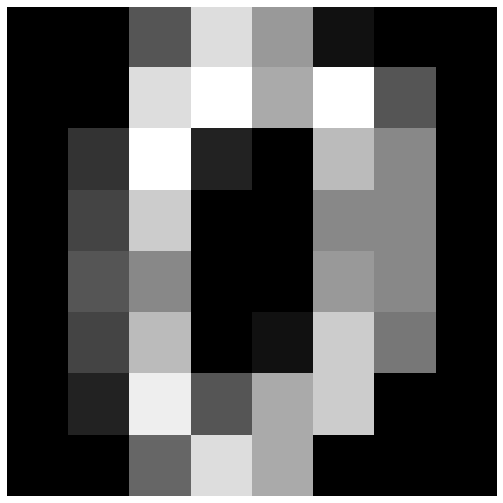

In [16]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [17]:
print('Number of clusters: ', len(np.unique(y)))

Number of clusters:  10


In [51]:
def algorithm_selection(X, y_true, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    if not set(distances) <= set(['euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square']):
        raise ValueError("available distances are: 'euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square'")
    if not set(algorithms) <= set(['average', 'single', 'complete']):
        raise ValueError("available algorithms are:'average', 'single', 'complete'")
    if not set(metrics) <= set(['homogenity', 'completeness', 'v_measure','silhouette']):
        raise ValueError("available metrics are: 'homogenity', 'completeness', 'v_measure','silhouette'")
         
    y_len = len(np.unique(y_true))
    compare_dataframe = pd.DataFrame(columns=['distans','linkage',
                                              'homogenity', 'completeness', 'v_measure','silhouette'])
    ind = 0
    for alg in algorithms:
        for dist in distances:
            if dist == 'chi-square':
                model = AgglomerativeClustering(n_clusters=y_len,affinity='precomputed', linkage=alg)
                chisq = chi2_kernel(X)
                labels = model.fit_predict(chisq, X)
            else:
                model = AgglomerativeClustering(n_clusters=y_len,affinity=dist,linkage=alg)
                labels = model.fit_predict(X)
            row =  [dist] + [alg]
            for met in metrics:
                if met == 'homogenity':
                    row += [homogeneity_score(y_true, labels)]
                elif met == 'completeness':
                    row += [completeness_score(y_true, labels)]
                elif met == 'v_measure':
                    row += [v_measure_score(y_true, labels)]
                else:
                    row += [silhouette_score(X, labels)]
            compare_dataframe.loc[ind] = row
            ind +=1
                    
                
            
    
    return compare_dataframe

In [19]:
algorithm_selection(X, y_true=y, distances=['euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square'],
                    algorithms=['average', 'single', 'complete'],
                    metrics=['homogenity', 'completeness', 'v_measure','silhouette'])

distans   linkage  homogenity  completeness  v_measure  silhouette
0    euclidean   average    0.655393      0.782342   0.713263    0.146625
1           l1   average    0.566751      0.778942   0.656117    0.089217
2    manhattan   average    0.566751      0.778942   0.656117    0.089217
3       cosine   average    0.648268      0.808762   0.719676    0.129526
4     canberra   average    0.573860      0.779789   0.661161    0.094335
5   chi-square   average    0.003367      0.003473   0.003419   -0.012602
6    euclidean    single    0.005056      0.273755   0.009929   -0.133621
7           l1    single    0.005102      0.276237   0.010019   -0.166627
8    manhattan    single    0.005102      0.276237   0.010019   -0.166627
9       cosine    single    0.005050      0.273389   0.009916   -0.158250
10    canberra    single    0.006144      0.280506   0.012025   -0.181136
11  chi-square    single    0.005108      0.276560   0.010031   -0.221525
12   euclidean  complete    0.590549      0.637772   0.613253    0.119271
13          l1  complete    0.646372      0.686109   0.665648    0.140183
14   manhattan  complete    0.646372      0.686109   0.665648    0.140183
15      cosine  complete    0.528727      0.577415   0.551999    0.088021
16    canberra  complete    0.528702      0.561588   0.544649    0.099416
17  chi-square  complete    0.003565      0.003609   0.003587   -0.009365

Лучший алгортим оказался: distance – __cosine/euclidean__,  linkage – __average__

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [20]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [21]:
fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c  
0    -1.406912  0.384406  
1     6.034845  0.577039  
2    -0.318668 -0.493832  
3     0.694883  3.416960  
4     5.563345  0.471591  
...        ...       ...  
9995 -0.591343  2.857737  
9996  0.344169 -0.626795  
9997 -0.887078  4.369294  
9998 -0.112999  0.069239  
9999 -0.441455  0.378331  

[10000 rows x 9 columns]

In [23]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [24]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [25]:
fc_data.shape

(10000, 9)

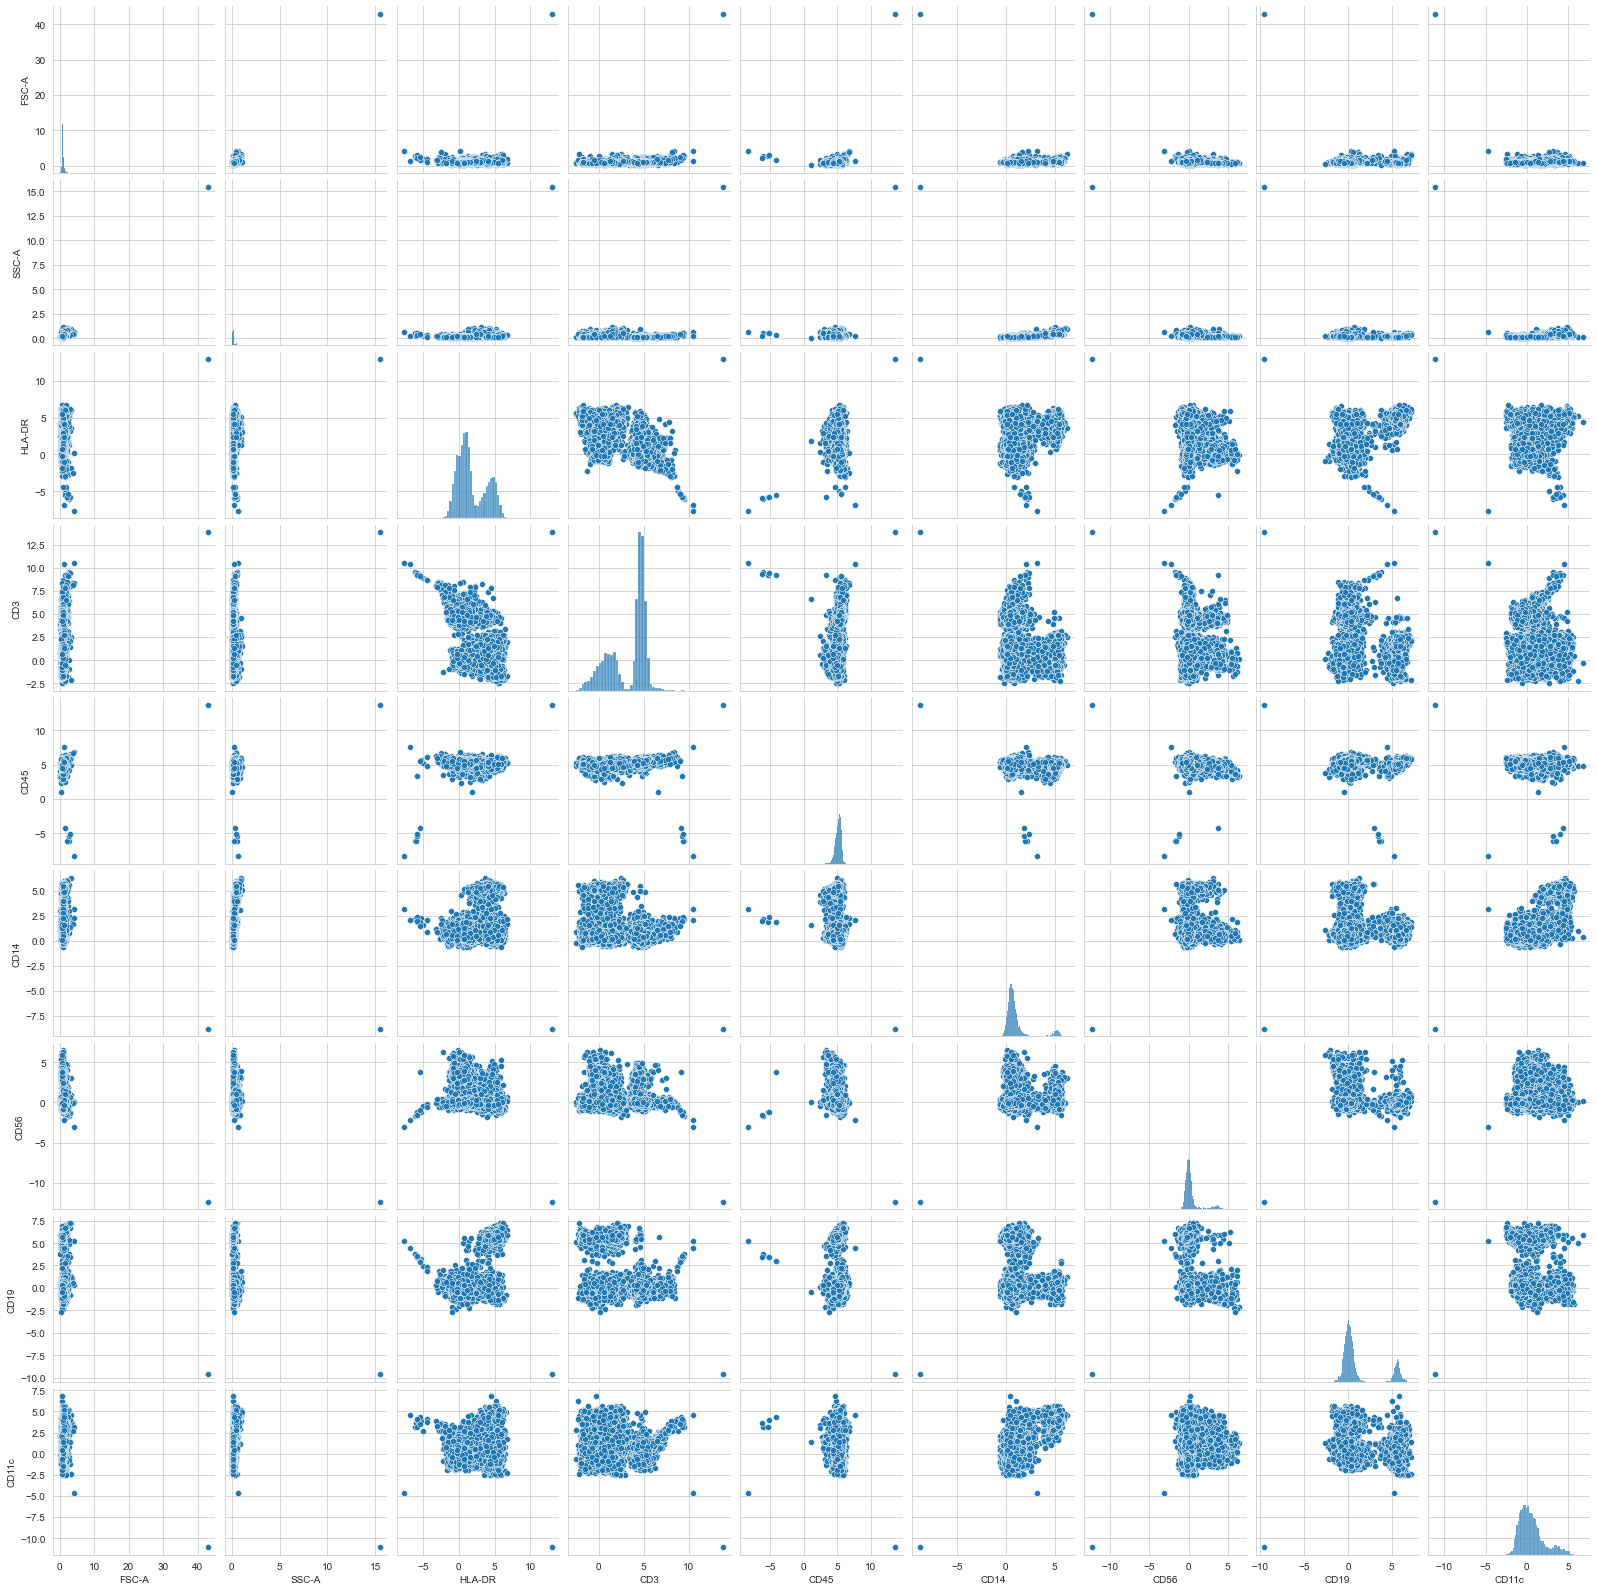

In [26]:
sns.pairplot(fc_data);

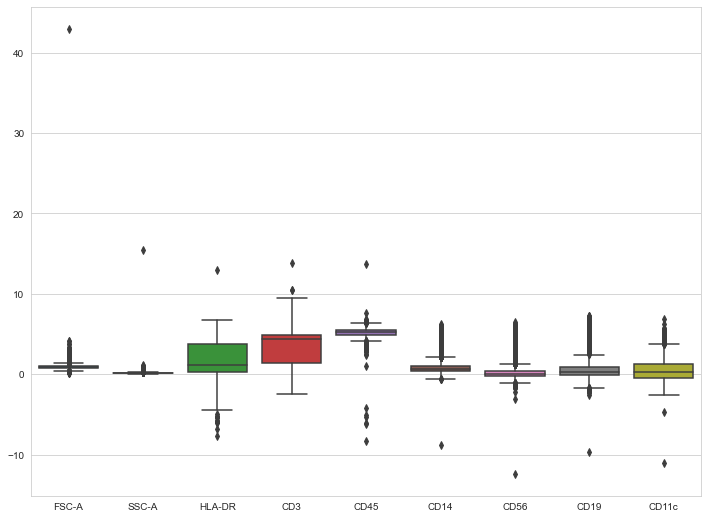

In [31]:
sns.boxplot(data=fc_data);

Сильный выброс в колонке FSC-A

In [43]:
fc_data = fc_data.drop(index=fc_data[fc_data['FSC-A']== np.max(fc_data['FSC-A'])].index[0]) #. Данные без большого выброса

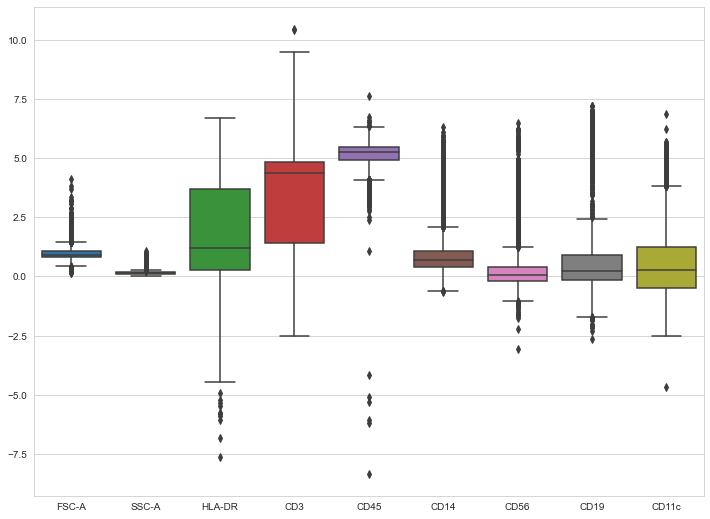

In [44]:
sns.boxplot(data=fc_data);

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [73]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

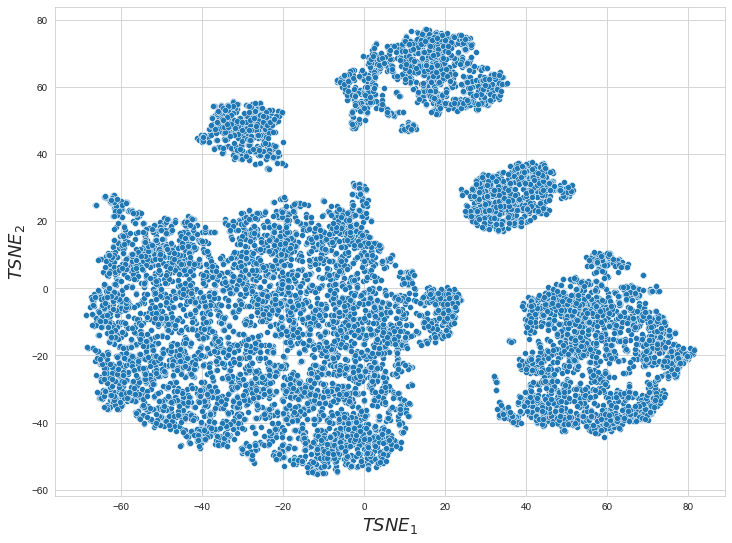

In [46]:
tsne_res = plot_tsne(fc_data) # Красиво получилось

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Выглядит так, что здесь __5__ кластеров

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

In [63]:
# Перепишем algortihm_selection для подбора лучшей иерархической кластеризации:
def algorithm_selection_tsne(X,n_clusters, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    if not set(distances) <= set(['euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square']):
        raise ValueError("available distances are: 'euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square'")
    if not set(algorithms) <= set(['average', 'single', 'complete']):
        raise ValueError("available algorithms are:'average', 'single', 'complete'")
         
    compare_dataframe = pd.DataFrame(columns=['distans','linkage',
                                              'silhouette'])
    ind = 0
    for alg in algorithms:
        for dist in distances:
            if dist == 'chi-square':
                model = AgglomerativeClustering(n_clusters=n_clusters,affinity='precomputed', linkage=alg)
                chisq = chi2_kernel(abs(X))
                labels = model.fit_predict(chisq, X)
            else:
                model = AgglomerativeClustering(n_clusters=n_clusters,affinity=dist,linkage=alg)
                labels = model.fit_predict(X)
            row =  [dist] + [alg] + [silhouette_score(X, labels)]
            compare_dataframe.loc[ind] = row
            ind +=1
                    
                
            
    
    return compare_dataframe

In [61]:
algorithm_selection_tsne(fc_data,n_clusters=5,distances=['euclidean', 'l1','manhattan', 'cosine', 'canberra', 'chi-square'],
                        algorithms=['average', 'single', 'complete'],metrics='silhouette')

distans   linkage  silhouette
0    euclidean   average    0.513811
1           l1   average    0.610444
2    manhattan   average    0.610444
3       cosine   average    0.613270
4     canberra   average    0.213518
5   chi-square   average   -0.416522
6    euclidean    single    0.198045
7           l1    single    0.594307
8    manhattan    single    0.594307
9       cosine    single    0.198045
10    canberra    single   -0.023613
11  chi-square    single   -0.158887
12   euclidean  complete    0.521228
13          l1  complete    0.478856
14   manhattan  complete    0.478856
15      cosine  complete    0.605964
16    canberra  complete    0.591551
17  chi-square  complete   -0.009808

In [64]:
# Посмотрим, что выдает Иерархическая кластеризация с косинусным расстоянием и average linkage:
model = AgglomerativeClustering(n_clusters=5, linkage='average', affinity='cosine')

In [65]:
model.fit(X)

AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=5)

In [79]:
prediction = model.fit_predict(fc_data)

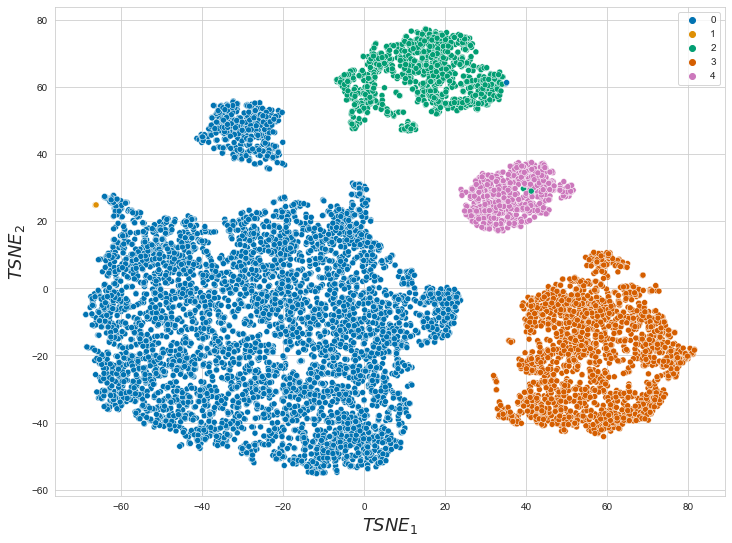

In [81]:
plot_tsne(fc_data,color=prediction);


__Not bad__. Но только находит 4 кластера (1 похож на выброс). Можно попробовать по-другому:

In [99]:
# Посмотрим, что выдает Иерархическая кластеризация с косинусным расстоянием и average linkage и 4 кластерами:
model = AgglomerativeClustering(n_clusters=4, linkage='average', affinity='cosine')

In [100]:
prediction = model.fit_predict(fc_data)

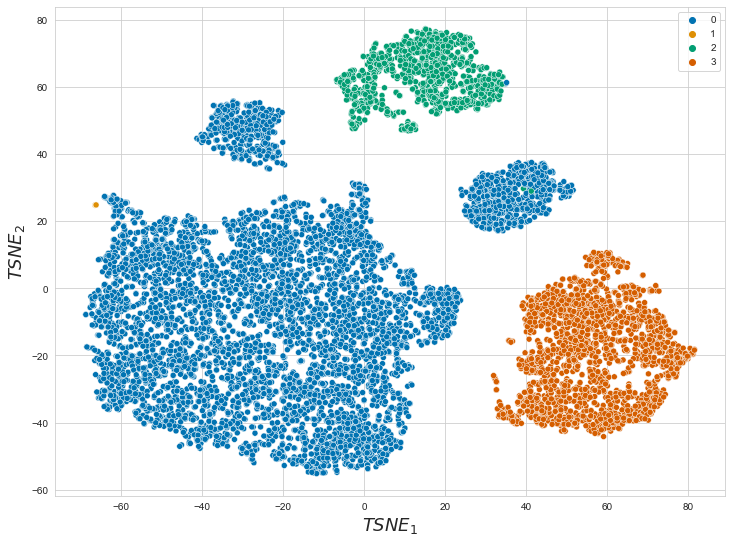

In [101]:
plot_tsne(fc_data,color=prediction);

Стало хуже

In [92]:
# Чуть изменим гиперапараметрыс на основе таблички
model = AgglomerativeClustering(n_clusters=5, linkage='complete', affinity='manhattan')

In [93]:
prediction = model.fit_predict(fc_data)

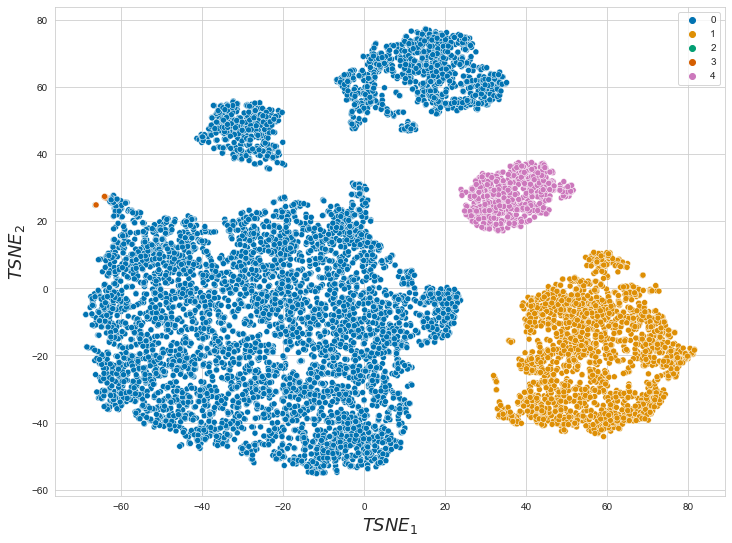

In [95]:
plot_tsne(fc_data,color=prediction);

Тоже не очень хорошо

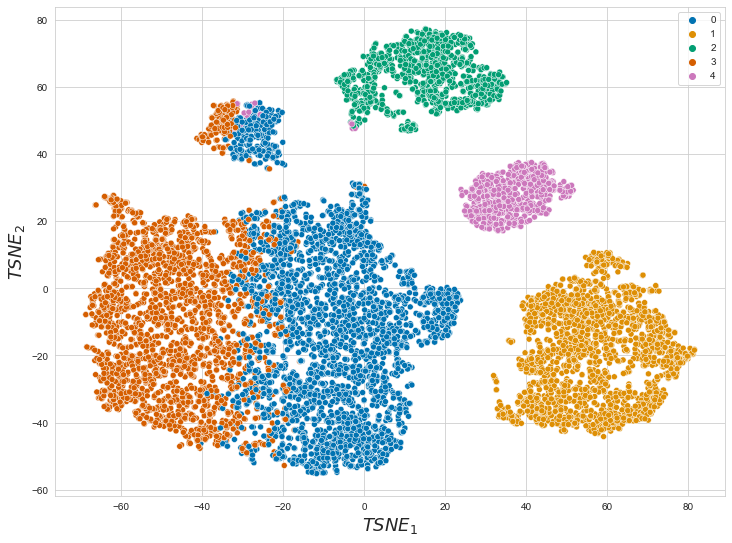

In [97]:
# Попробуем Kmeans:
model = KMeans(n_clusters=5)
prediction = model.fit_predict(fc_data)
plot_tsne(fc_data,color=prediction);

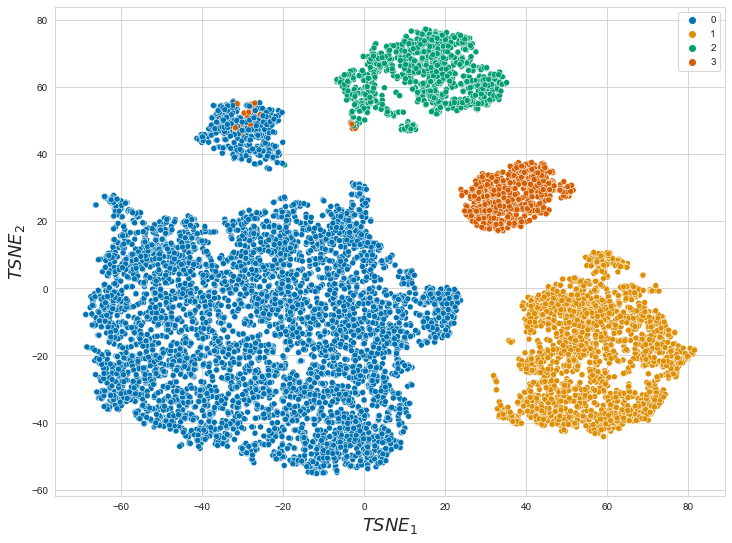

In [98]:
# Попробуем Kmeans c 4 кластерами:
model = KMeans(n_clusters=4)
prediction = model.fit_predict(fc_data)
plot_tsne(fc_data,color=prediction);

Этот алгоритм выглядит самым подходящим (4 кластера, основываясь на слудеющем задании - это ОК)

Вдобавок попробуем DBSCAN

In [102]:
from sklearn.cluster import DBSCAN

In [131]:
model = DBSCAN(eps=1.6)
prediction = model.fit_predict(fc_data)

In [132]:
np.unique(prediction,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([ 146,  621, 1976, 6194, 1041,   15,    5]))

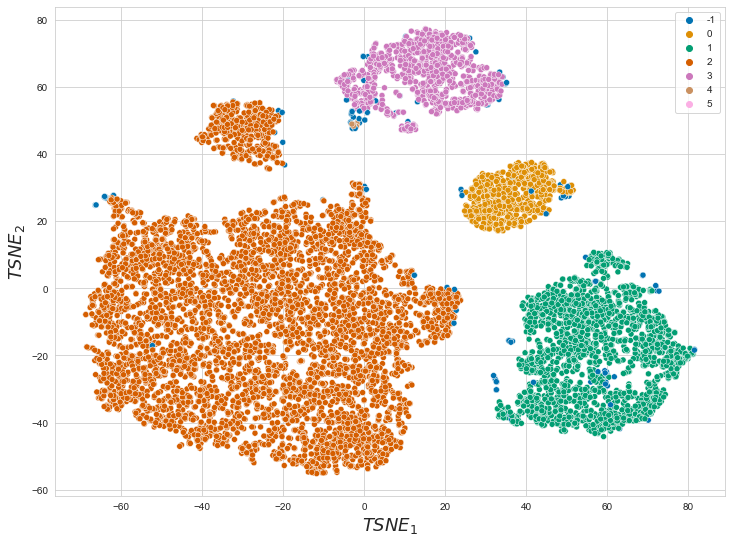

In [133]:
plot_tsne(fc_data,color=prediction);

Вывод – не умею подбирать гиперпараметры для DBSCAN

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

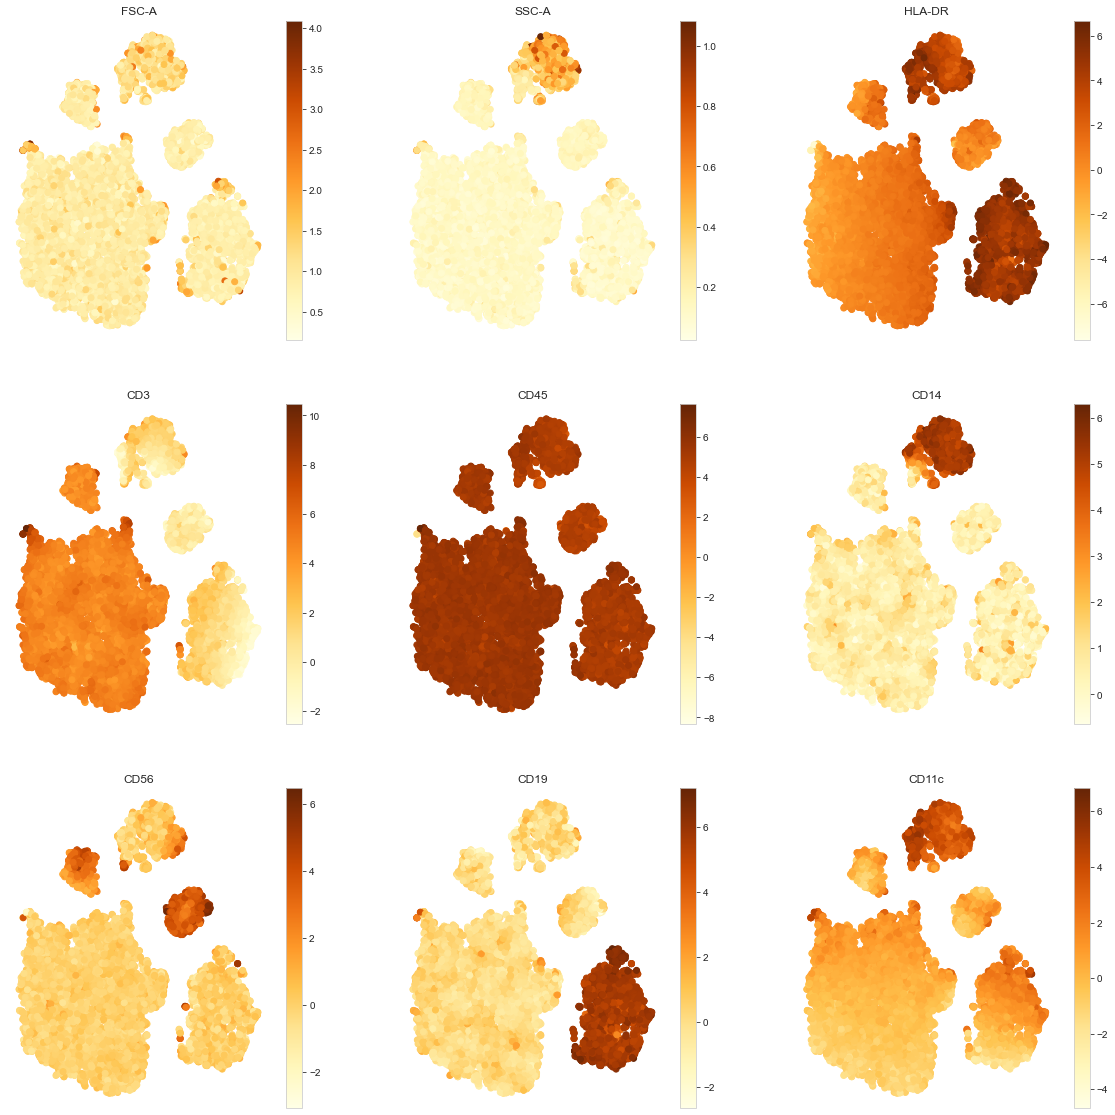

In [136]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [144]:
cell_type_cluster_map = {0: "Other cells", 
                         1: "B_cells", 
                         2: "T_cells", 
                         3: "Monocytes"}
clust =  KMeans(n_clusters=4).fit(fc_data)

In [145]:
labeled_fc_data = fc_data.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [146]:
labeled_fc_data.Population.value_counts()

Other cells    6201
B_cells        2035
T_cells        1091
Monocytes       671
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [147]:
labeled_fc_data.to_csv('../data/result.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

В связи с текущими обстоятельствами хотелось бы этой весной остаться дома и никуда (сособенно в западном направлении) не ехать. А так люблю природу, но хотел бы съездить к бабушке, она в поселеке живет, виды там такие себе.

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Было интересно, но сложно, пришлось много гуглить дополнительно. Хотя, оглядываясь назад, кажется, что все понятно. Но первоначальный вид - сильно пугает.